In [30]:
%load_ext autoreload
%autoreload 3 --log
%autoreload?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Docstring:
::

  %autoreload [-p] [-l] [--hide-errors] [mode]

%autoreload => Reload modules automatically

%autoreload or %autoreload now
Reload all modules (except those excluded by %aimport) automatically
now.

%autoreload 0 or %autoreload off
Disable automatic reloading.

%autoreload 1 or %autoreload explicit
Reload only modules imported with %aimport every time before executing
the Python code typed.

%autoreload 2 or %autoreload all
Reload all modules (except those excluded by %aimport) every time
before executing the Python code typed.

%autoreload 3 or %autoreload complete
Same as 2/all, but also but also adds any new objects in the module. See
unit test at IPython/extensions/tests/test_autoreload.py::test_autoload_newly_added_objects

The optional arguments --print and --log control display of autoreload activity. The default
is to act silently; --print (or -p) will print out the names of modules that are being
reloaded, and --log (or -l) outputs them to the log at INFO level.

In [31]:
import torch
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.hmc import HMC
from pyro.contrib.gp.kernels import RBF
from pyro.contrib.gp.util import conditional

In [32]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_device(device)
else:
    device = torch.device('cpu')

torch.set_default_dtype(torch.float64)

print(f"Using device: {device}")

Using device: cuda


In [33]:
# Define the log Gaussian Cox process model
# gamma in our experiment is 0.12, due to gamma = 1 / 2 l^2 we have l = 2.04
def log_gaussian_cox_process(
    data, kernel_lengthscale=torch.tensor(2.04), kernel_variance=torch.tensor(1.0), area=torch.tensor(1.0)
):
    x = data["x"]
    y = data["y"]
    # Define the RBF kernel with fixed hyperparameters
    kernel = RBF(input_dim=2, lengthscale=kernel_lengthscale, variance=kernel_variance)

    # Sample from the GP prior
    K = kernel(x) + 1e-6 * torch.eye(x.shape[0])  # Add jitter for numerical stability
    f = pyro.sample("f", dist.MultivariateNormal(torch.zeros(x.shape[0]), K))

    # Transform GP samples to intensity function
    intensity = torch.exp(f)

    # Define the Poisson likelihood
    with pyro.plate("data", x.shape[0]):
        return pyro.sample("obs", dist.Poisson(intensity * area), obs=y)


In [34]:
from utils import *

obs, dt, gdf = get_taxi_data(200)
obs = obs.to(device)

In [35]:
# Define the grid size
grid_size = 30

# Create evenly spaced values between -1 and 1
x_edges = torch.linspace(-1, 1, grid_size + 1, dtype=torch.float64)
y_edges = torch.linspace(-1, 1, grid_size + 1, dtype=torch.float64)

# Initialize the count tensor
counts = torch.zeros((grid_size, grid_size), dtype=torch.float64)

# Count the number of points in each bin
for point in obs:
    x_idx = torch.searchsorted(x_edges, point[0], right=True) - 1
    y_idx = torch.searchsorted(y_edges, point[1], right=True) - 1
    if 0 <= x_idx < grid_size and 0 <= y_idx < grid_size:
        counts[x_idx, y_idx] += 1

counts = counts.view(-1)
print(sum(counts))

tensor(198., device='cuda:0')


In [36]:
discretizaion = 30
left, down, right, up = gdf.total_bounds
xtest_orig = get_grid(discretizaion, left, down, right, up)


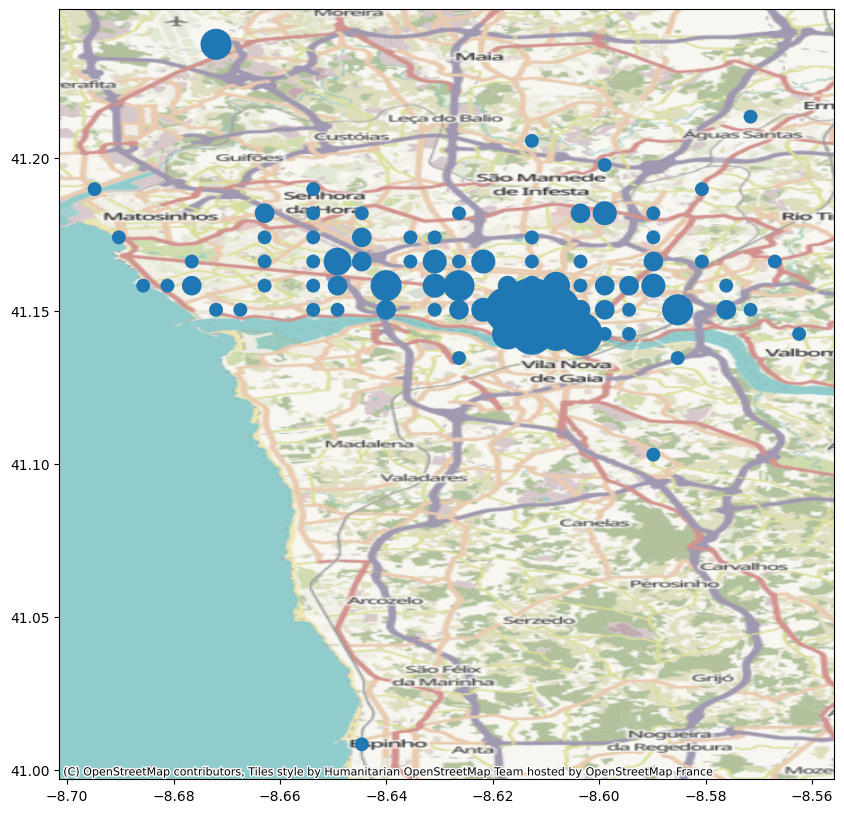

In [37]:
# Parameters
import contextily as ctx
import matplotlib.pyplot as plt


# Prepare coordinates for plotting
xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Define a scaling factor for the sizes based on mean values
scale_factor = 100  # Adjust this factor as needed for visual clarity

# Scatter plot with mean values as size and std as color using viridis colormap
scatter = ax.scatter(
    xx.cpu(),
    yy.cpu(),
    s=counts.cpu() * scale_factor,  # Scale point size by mean values
    alpha=1.0,
    edgecolor="face",
    linewidth=0.0,
    marker="o",
)

ctx.add_basemap(ax, crs=gdf.crs.to_string())

plt.show()

In [38]:
x = get_grid(30, -1, -1, 1, 1)
y = counts
x = x
y = y

data = {"x": x, "y": y}
mala_kernel = HMC(log_gaussian_cox_process, step_size=0.1, num_steps=1)
mcmc = MCMC(mala_kernel, num_samples=500, warmup_steps=200)
mcmc.run(data)
samples = mcmc.get_samples()
samples

Warmup:   0%|          | 0/700 [00:00, ?it/s]

Sample: 100%|██████████| 700/700 [04:35,  2.54it/s, step size=2.16e-02, acc. prob=0.875]


{'f': tensor([[-0.6387, -0.6426, -0.6440,  ..., -0.3249, -0.3683, -0.4127],
         [-0.6387, -0.6426, -0.6440,  ..., -0.3249, -0.3683, -0.4127],
         [-0.6387, -0.6426, -0.6440,  ..., -0.3249, -0.3683, -0.4127],
         ...,
         [-0.6557, -0.6593, -0.6580,  ..., -0.3225, -0.3632, -0.4077],
         [-0.6547, -0.6588, -0.6605,  ..., -0.3215, -0.3631, -0.4071],
         [-0.6549, -0.6585, -0.6591,  ..., -0.3218, -0.3633, -0.4090]],
        device='cuda:0')}

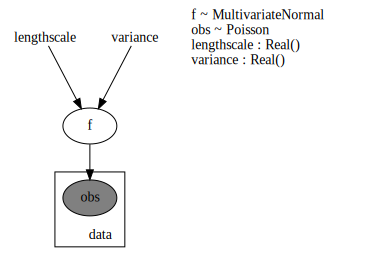

In [39]:
pyro.render_model(log_gaussian_cox_process, model_args=(data,), render_distributions=True, render_params=True)

In [40]:
samples = torch.exp(samples['f'])

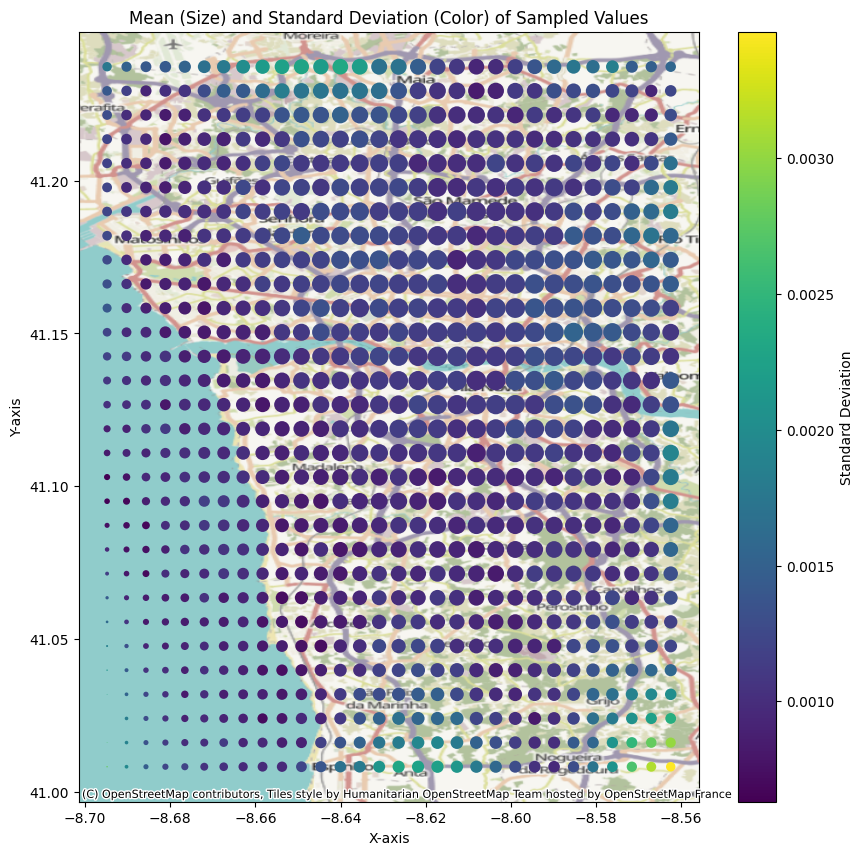

In [41]:
# Prepare coordinates for plotting
xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

# Calculate mean and standard deviation across samples at each point
mean_values = torch.mean(samples, dim=0)
std_values = torch.std(samples, dim=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Define a scaling factor for the sizes based on mean values
scale_factor = 100  # Adjust this factor as needed for visual clarity

# Scatter plot with mean values as size and std as color using viridis colormap
scatter = ax.scatter(
    xx.cpu(),
    yy.cpu(),
    c=std_values.cpu(),
    cmap="viridis",
    s=(mean_values.cpu() - torch.min(mean_values).cpu())
    * 400,  # Scale point size by mean values
    alpha=1.0,
    edgecolor="face",
    linewidth=0.0,
    marker="o",
)

ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Color bar for the standard deviation (variance)
cbar = fig.colorbar(scatter, ax=ax, label="Standard Deviation")

# Labeling
ax.set_title("Mean (Size) and Standard Deviation (Color) of Sampled Values")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

plt.show()

In [42]:
print(f"Mean in [{torch.min(mean_values)}, {torch.max(mean_values)}] and std in [{torch.min(std_values)}, {torch.max(std_values)}]")

Mean in [0.5218223680437147, 1.0309106068291591] and std in [0.0006303436788591454, 0.0034653169637728406]


In [43]:
expected_num_points = mean_values.sum(0)
expected_num_points

tensor(731.0766, device='cuda:0')

In [44]:
len(obs)

200